In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1

We can implement all of the explicit methods in terms of their butcher tableau so that they can reuse a lot of the same code.

In [2]:
from pna import ivp_explicit

%psource ivp_explicit

import numpy as np

# define the explicit methods in terms of their butch tableau


class _EulerStep:
    """Defines Butcher Tableau for the Forward Euler method."""

    A = np.array([[0]])
    B = np.array([1])
    C = np.array([0])


class _HeunsStep:
    """Defines the Butcher Tableau for Huan's method."""

    A = np.array([[0, 0], [1, 0]])
    B = np.array([0.5, 0.5])
    C = np.array([0, 1])


class _RK4Step:
    """Butcher Tableau for the classic fourth-order Rung-Kutta method."""

    A = np.array([[0, 0, 0, 0], [0.5, 0, 0, 0], [0, 0.5, 0, 0], [0, 0, 1, 0]])
    B = np.array([1 / 6, 1 / 3, 1 / 3, 1 / 6])
    C = np.array([0, 0.5, 0.5, 1])


_fixed_step_methods = {
    "euler": _EulerStep(),
    "heun": _HeunsStep(),
    "rk4": _RK4Step(),
}


def solve_to_fixed_step(f, y0, t_span, dt, method):
    """Solves ODE using a fixed timestep.

    Parameters
    ----------
    f : Callable
        ODE to solve. Must have signature f(t, y) -> array_like
    y0 : np.ndarray
        Init

We can also define functions for the implicit methods.

In [3]:
from pna import ivp_implicit

%psource ivp_implicit

import numpy as np
from scipy.optimize import root


def implicit_solve_to(f, y0, t_span, dt, method):
    """Solves ODE using the implicit euler method / Crank Nicolson.

    Parameters
    ----------
    f : Callable
        ODE to solve. Must have signature f(t, y) -> array_like
    y0 : np.ndarray
        Initial condition
    t_span : tuple[float, float]
        Time span to solve over
    dt : float
        Step size to use
    method : str
        method to use. Options are "euler", "CN"

    Returns
    -------
    y
        Solution to f
    t
        Time corresponding to solution y
    """
    t = [t_span[0]]
    y = [np.asarray(y0)]

    # define function to find root of
    if method == "euler":

        def f_root(y_next):
            return y_next - y[-1] - dt * f(t[-1] + dt, y_next)

    elif method == "CN":

        def f_root(y_next):
            return y_next - y[-1] - 0.5 * dt * (f(t[-1] + dt, y_next) + f(t[-1], y[-1]))

    else:
        raise ValueError("Invalid M

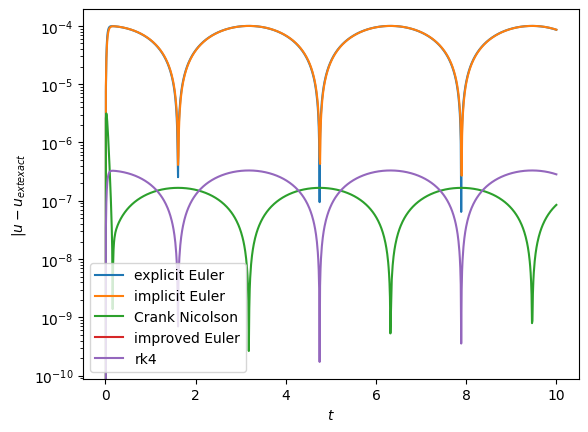

In [8]:
dt = 0.01
y0 = [1]
t_span = (0, 10)


# define the right handside of the ode
def rhs(t, u):
    return np.asarray(-50 * (u - np.cos(t)))


# define true solution
def u_exact(t):
    return (
        (2500 / 2501) * np.cos(t)
        + (50 / 2501) * np.sin(t)
        + (1 / 2501) * np.exp(-50 * t)
    )


# calculate solution using explicit euler
u_euler, t_euler = ivp_explicit.solve_to_fixed_step(
    rhs, y0=y0, t_span=t_span, dt=dt, method="euler"
)

# calculate solution using implicit euler
u_euler_implicit, t_euler_implicit = ivp_implicit.implicit_solve_to(
    rhs, y0=y0, t_span=t_span, dt=dt, method="euler"
)

# calculate solution using Crank Nicolson
u_CN, t_CN = ivp_implicit.implicit_solve_to(
    rhs, y0=y0, t_span=t_span, dt=dt, method="CN"
)

# calculate solution using improved Euler scheme
u_improved_euler, t_improved_euler = ivp_explicit.solve_to_fixed_step(
    rhs, y0=y0, t_span=t_span, dt=dt, method="heun"
)

# calculate solution using RK4
u_rk4, t_rk4 = ivp_explicit.solve_to_fixed_step(
    rhs, y0=y0, t_span=t_span, dt=dt, method="rk4"
)

fig, ax = plt.subplots()
ax.plot(t_euler, np.abs(u_euler[0] - u_exact(t_euler)), label="explicit Euler")
ax.plot(
    t_euler,
    np.abs(u_euler_implicit[0] - u_exact(t_euler_implicit)),
    label="implicit Euler",
)
ax.plot(t_CN, np.abs(u_CN[0] - u_exact(t_CN)), label="Crank Nicolson")
ax.plot(
    t_improved_euler,
    np.abs(u_improved_euler[0] - u_exact(t_improved_euler)),
    label="improved Euler",
)
ax.plot(t_rk4, np.abs(u_rk4[0] - u_exact(t_rk4)), label="rk4")

ax.set_yscale("log")
ax.set_xlabel("$t$")
ax.set_ylabel("$|u - u_{\text{exact}}$")
ax.legend()

Here we see that Crank Nicolson has the lowest error and implicit/explicit euler the highest error. The error for Crank Nicolson is out of phase with the other methods as its error is proportional to the third devivate, whereas the other methods the error is proportional to the second derivative.

Next we will verify the rate of convergence for each method.

In [9]:
N = np.logspace(8, 16, 9, base=2, dtype=int)

explicit_euler_err = []
implicit_euler_err = []
CN_err = []
improved_euler_err = []
rk4_err = []

for n in N:
    dt = 10 / n

    u_euler, t_euler = ivp_explicit.solve_to_fixed_step(
        rhs, y0=y0, t_span=t_span, dt=dt, method="euler"
    )
    explicit_euler_err.append(np.abs(u_euler[:, -1] - u_exact(t_euler[-1])))

    u_euler_implicit, t_euler_implicit = ivp_implicit.implicit_solve_to(
        rhs, y0=y0, t_span=t_span, dt=dt, method="euler"
    )
    implicit_euler_err.append(
        np.abs(u_euler_implicit[:, -1] - u_exact(t_euler_implicit[-1]))
    )

    u_CN, t_CN = ivp_implicit.implicit_solve_to(
        rhs, y0=y0, t_span=t_span, dt=dt, method="CN"
    )
    CN_err.append(np.abs(u_CN[:, -1] - u_exact(t_CN[-1])))

    u_improved_euler, t_improved_euler = ivp_explicit.solve_to_fixed_step(
        rhs, y0=y0, t_span=t_span, dt=dt, method="heun"
    )
    improved_euler_err.append(
        np.abs(u_improved_euler[:, -1] - u_exact(t_improved_euler[-1]))
    )

    u_rk4, t_rk4 = ivp_explicit.solve_to_fixed_step(
        rhs, y0=y0, t_span=t_span, dt=dt, method="rk4"
    )
    rk4_err.append(np.abs(u_rk4[:, -1] - u_exact(t_rk4[-1])))

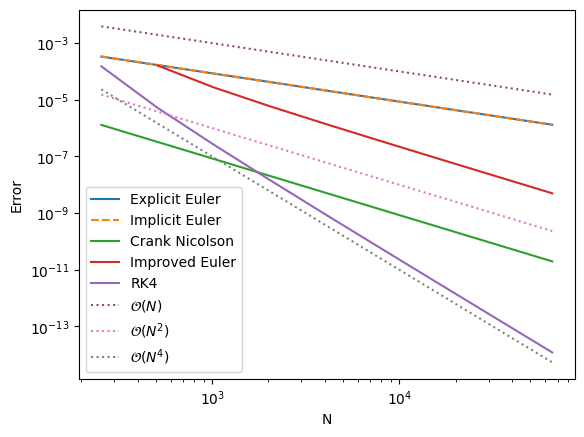

In [10]:
fig, ax = plt.subplots()
ax.loglog(N, explicit_euler_err, label="Explicit Euler")
ax.loglog(N, implicit_euler_err, "--", label="Implicit Euler")
ax.loglog(N, CN_err, label="Crank Nicolson")
ax.loglog(N, improved_euler_err, label="Improved Euler")
ax.loglog(N, rk4_err, label="RK4")

# plot different orders of convergence
ax.loglog(N, N.astype(float) ** (-1), ":", label="$\mathcal{O}(N)$")
ax.loglog(N, N.astype(float) ** (-2), ":", label="$\mathcal{O}(N^2)$")
ax.loglog(N, 1e5 * N.astype(float) ** (-4), ":", label="$\mathcal{O}(N^4)$")

ax.set_xlabel("N")
ax.set_ylabel("Error")
ax.legend()

Here we see first order convergence for explicit & implicit Euler, second order convergence for Crank Nicolson and Improved Euler, and fourth order convergence for the classic Runge Kutta scheme.

# Question 2

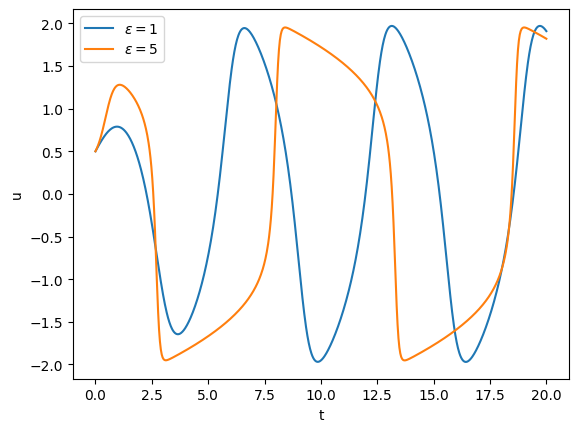

In [7]:
def rhs(t, u, epsilon):
    return np.array([u[1], epsilon * (1 - u[0] ** 2) * u[1] - u[0]])


t_span = (0, 20)
dt = t_span[-1] / 1000
u0 = [1 / 2, 1 / 2]

u1, t1 = ivp_implicit.implicit_solve_to(
    lambda t, x: rhs(t, x, 1), t_span=t_span, dt=dt, y0=u0, method="euler"
)
u2, t2 = ivp_implicit.implicit_solve_to(
    lambda t, x: rhs(t, x, 5), t_span=t_span, dt=dt, y0=u0, method="euler"
)


fig, ax = plt.subplots()
ax.plot(t1, u1[0, :], label="$\epsilon = 1$")
ax.plot(t2, u2[0, :], label="$\epsilon = 5$")
ax.set_xlabel("t")
ax.set_ylabel("u")
ax.legend()

As expected here we see a stable limit cycle (there is a Hopf bifurcation at $\epsilon = 0$). As $\epsilon$ increases the period of the limit cycle has increased. This is also expected as we would expect the period to scale like $\sqrt{\epsilon}$.